# Louvain Performance Benchmarking

This notebook benchmarks performance improvement of running the Louvain clustering algorithm within cuGraph against NetworkX. The test is run over eight test networks (graphs) and then results plotted.  
<p><p>


#### Notebook Credits

    Original Authors: Bradley Rees
    Last Edit: 04/09/2019


#### Test Environment

    RAPIDS Versions: 0.6.0

    GP100 32G, CUDA 9,2
    Dual Intel(R) Xeon(R) CPU E5-2643 v4 @ 3.40GHz
    64GB system memory


#### Updates
- moved loading ploting libraries to front so that dependencies can be checked before running algorithms
- added edge values 
- changed timing to including Graph creation for both cuGraph and NetworkX.  This will better represent end-to-end times



#### Dependencies
- RAPIDS cuDF and cuGraph version 0.6.0 
- NetworkX 
- Matplotlib 
- Scipy 
- data prep script run



#### Note: Comparison against published results


The cuGraph blog post included performance numbers that were collected over a year ago.  For the test graphs, int32 values are now used.  That improves GPUs performance.  Additionally, the initial benchamrks were measured on a P100 GPU. 

This test only comparse the modularity scores and a success is if the scores are within 15% of each other.  That comparison is done by adjusting the NetworkX modularity score and then verifying that the cuGraph score is higher.

cuGraph did a full validation of NetworkX results against cuGraph results.  That included cross-validation of every cluster.  That test is very slow and not included here

In [1]:
# Import needed libraries
import time
import cugraph
import cudf

In [2]:
# NetworkX libraries
import community
import networkx as nx
from scipy.io import mmread

In [3]:
# Loading plotting libraries
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

### Define the test data

In [4]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

### Define the testing functions

In [5]:
# Read in a dataset in MTX format 
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    d = mmread(mm_file).asfptype()
    M = d.tocsr()
    
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')
        
    return M

In [6]:
# Run the cuGraph Louvain analytic (using nvGRAPH function)
def cugraph_call(M):

    t1 = time.time()

    # data
    row_offsets = cudf.Series(M.indptr)
    col_indices = cudf.Series(M.indices)
    data        = cudf.Series(M.data)
    
    # create graph 
    G = cugraph.Graph()
    G.add_adj_list(row_offsets, col_indices, data)

    # cugraph Louvain Call
    print('  cuGraph Solving... ')
    df, mod = cugraph.nvLouvain(G)   
    
    t2 = time.time() - t1
    return t2, mod


In [7]:
# Run the NetworkX Louvain analytic.  THis is done in two parts since the modularity score is not returned 
def networkx_call(M):
   
    t1 = time.time()

    # Directed NetworkX graph
    Gnx = nx.Graph(M)

    # Networkx 
    print('  NetworkX Solving... ')
    parts = community.best_partition(Gnx)
    
    # Calculating modularity scores for comparison 
    mod = community.modularity(parts, Gnx)   
    
    t2 = time.time() - t1
    
    return t2, mod

### Run the benchmarks

In [8]:
# Loop through each test file and compute the speedup
perf  = []
names = []

for k,v in data.items():
    M = read_mtx_file(v)
    tr, modc = cugraph_call(M)
    tn, modx = networkx_call(M)
    
    speedUp = (tn / tr)
    names.append(k)
    perf.append(speedUp)
    
    mod_delta = (0.85 * modx)
    
    print(str(speedUp) + "x fatser =>  cugraph " + str(tr) + " vs " + str(tn))
    print("Modularity =>  cugraph " + str(modc) + " should be greater than " + str(mod_delta))

Reading ./data/preferentialAttachment.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
2344.2160923881643x fatser =>  cugraph 0.9594738483428955 vs 2249.214035511017
Modularity =>  cugraph 0.19461682219817675 should be greater than 0.20806561327583747
Reading ./data/caidaRouterLevel.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
2293.4453926935234x fatser =>  cugraph 0.1047067642211914 vs 240.13924598693848
Modularity =>  cugraph 0.7872923202092253 should be greater than 0.7294696890786043
Reading ./data/coAuthorsDBLP.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
7688.488080469727x fatser =>  cugraph 0.09936165809631348 vs 763.9409239292145
Modularity =>  cugraph 0.7648739273488195 should be greater than 0.7012939044778534
Reading ./data/dblp-2010.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
4806.749982230856x fatser =>  cugraph 0.120758056640625 vs 580.453786611557
Modularity =>  cugraph 0.7506256512679915 should be greater than 0.7456758234490394
Reading ./data/c

### plot the output

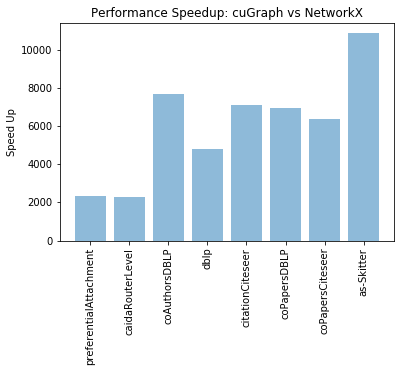

In [9]:
%matplotlib inline

y_pos = np.arange(len(names))
 
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, names)
plt.ylabel('Speed Up')
plt.title('Performance Speedup: cuGraph vs NetworkX')
plt.xticks(rotation=90) 
plt.show()